# Neural Network Approximator for Black–Scholes Implied Volatility
This notebook ingests an options CSV (e.g. generated via `download_options.py TICKER`) and trains a small neural network that maps option descriptors `(S0, K, T, C_mkt, moneyness)` to the Black–Scholes implied volatility computed via numerical inversion.

## 1. Imports and configuration

In [11]:
%matplotlib inline

import math
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)
plt.style.use("seaborn-v0_8")
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = lambda x: f"{x:,.6f}"
print(f'Using torch {torch.__version__}')


Using torch 2.5.1


## 2. Load dataset

In [12]:
DATA_TICKER = "SPY"  # change to match your CSV
local_candidate = Path(f"options_{DATA_TICKER}.csv")
parent_candidate = Path('..') / local_candidate
if local_candidate.exists():
    CSV_PATH = local_candidate
elif parent_candidate.exists():
    CSV_PATH = parent_candidate
else:
    raise FileNotFoundError(f"CSV not found near notebook: {local_candidate} / {parent_candidate}")

df = pd.read_csv(CSV_PATH)
required_cols = {"S0", "K", "C_mkt", "T"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

if 'type' not in df.columns:
    raise ValueError("CSV must include a 'type' column with 'C'/'P' values.")
df['type'] = df['type'].astype(str).str.upper()
df = df[df['type'].isin(['C','P'])].copy()
if df.empty:
    raise ValueError('Dataset contains no call or put rows after filtering.')

print(f'Loaded {CSV_PATH} with shape {df.shape}')
print(df['type'].value_counts())
display(df.head())


Loaded ../options_SPY.csv with shape (7624, 6)
type
C    3970
P    3654
Name: count, dtype: int64


,S0,K,C_mkt,T,type,iv
0,677.630127,350.000000,0.010000,0.000950,P,2.562504
1,677.630127,355.000000,0.020000,0.000950,P,2.500004
2,677.630127,360.000000,0.010000,0.000950,P,2.437504
3,677.630127,365.000000,0.010000,0.000950,P,2.375004
4,677.630127,370.000000,0.010000,0.000950,P,2.312504


## 3. Black–Scholes pricing helpers and implied volatility target

In [13]:
def normal_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def normal_pdf(x: float) -> float:
    return (1.0 / math.sqrt(2.0 * math.pi)) * math.exp(-0.5 * x * x)

def bs_price(S0: float, K: float, T: float, r: float, q: float, vol: float, call: bool = True) -> float:
    if T <= 0:
        intrinsic_call = max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0)
        intrinsic_put = max(K * math.exp(-r * T) - S0 * math.exp(-q * T), 0.0)
        return intrinsic_call if call else intrinsic_put
    vol = max(vol, 1e-8)
    sqrt_T = math.sqrt(T)
    d1 = (math.log(S0 / K) + (r - q + 0.5 * vol * vol) * T) / (vol * sqrt_T)
    d2 = d1 - vol * sqrt_T
    discount_dom = math.exp(-r * T)
    discount_for = math.exp(-q * T)
    if call:
        return S0 * discount_for * normal_cdf(d1) - K * discount_dom * normal_cdf(d2)
    return K * discount_dom * normal_cdf(-d2) - S0 * discount_for * normal_cdf(-d1)

def implied_vol_bs(C_mkt: float, S0: float, K: float, T: float, r: float, q: float = 0.0, call: bool = True) -> float:
    if T <= 0 or C_mkt <= 0:
        return float('nan')
    intrinsic = max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0) if call else max(K * math.exp(-r * T) - S0 * math.exp(-q * T), 0.0)
    if C_mkt < intrinsic - 1e-8:
        return float('nan')
    sigma = 0.3
    sqrt_T = math.sqrt(T)
    for _ in range(100):
        price_curr = bs_price(S0, K, T, r, q, sigma, call=call)
        diff = price_curr - C_mkt
        if abs(diff) < 1e-6:
            return float(sigma)
        denom = max(sigma, 1e-8) * sqrt_T
        d1 = (math.log(S0 / K) + (r - q + 0.5 * sigma * sigma) * T) / denom
        vega = S0 * math.exp(-q * T) * sqrt_T * normal_pdf(d1)
        if vega < 1e-10:
            break
        sigma = sigma - diff / vega
        if sigma <= 0:
            sigma = 1e-4
    return float(sigma)

RISK_FREE = 0.02
DIVIDEND = 0.0
sigmas = []
for _, row in df.iterrows():
    is_call = row['type'] == 'C'
    sigma = implied_vol_bs(row['C_mkt'], row['S0'], row['K'], row['T'], RISK_FREE, DIVIDEND, call=is_call)
    sigmas.append(sigma)
df['sigma_BS'] = sigmas
print('Computed implied vol for all rows.')
display(df[['S0','K','T','C_mkt','type','sigma_BS']].head())
display(df['sigma_BS'].describe())


Computed implied vol for all rows.


,S0,K,T,C_mkt,type,sigma_BS
0,677.630127,350.000000,0.000950,0.010000,P,0.300000
1,677.630127,355.000000,0.000950,0.020000,P,0.300000
2,677.630127,360.000000,0.000950,0.010000,P,0.300000
3,677.630127,365.000000,0.000950,0.010000,P,0.300000
4,677.630127,370.000000,0.000950,0.010000,P,0.300000


count            6,850.000000
mean         7,154,190.845676
std        311,881,058.632277
min                  0.000100
25%                  0.163516
50%                  0.222454
75%                  0.304829
max     18,105,878,126.278564
Name: sigma_BS, dtype: float64

## 4. Feature engineering and tensors

In [14]:
df = df.dropna(subset=['S0','K','T','C_mkt','sigma_BS','type']).copy()
df = df[(df['S0'] > 0) & (df['K'] > 0) & (df['T'] > 0)]
df['moneyness'] = df['S0'] / df['K']
df['is_call'] = (df['type'] == 'C').astype(np.float32)
feature_cols = ['S0','K','T','C_mkt','moneyness','is_call']
X = df[feature_cols].values.astype(np.float32)
y = df['sigma_BS'].values.astype(np.float32).reshape(-1, 1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X_norm = (X - X_mean) / X_std
X_tensor = torch.from_numpy(X_norm)
y_tensor = torch.from_numpy(y)
dataset = TensorDataset(X_tensor, y_tensor)
print(f'Dataset size: {len(dataset)} samples')


Dataset size: 6850 samples


## 5. Train/validation split and loaders

In [15]:
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
print(f'Train size: {train_size}, Validation size: {val_size}')


Train size: 5480, Validation size: 1370


## 6. Define neural network

In [16]:
class ImpliedVolNet(nn.Module):
    def __init__(self, input_dim: int, hidden: Tuple[int, int] = (64, 64)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden[0]),
            nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]),
            nn.ReLU(),
            nn.Linear(hidden[1], 1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def rmse_loss(preds: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    mse = torch.mean((preds - target) ** 2)
    return torch.sqrt(mse + 1e-12)

model = ImpliedVolNet(input_dim=X_tensor.shape[1])
criterion = rmse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


ImpliedVolNet(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 7. Training loop

Epoch 001 | Train RMSE 259503364.1372 | Val RMSE 466010627.3035
Epoch 020 | Train RMSE 259503336.8896 | Val RMSE 466010625.9656
Epoch 040 | Train RMSE 259503326.6205 | Val RMSE 466010570.1822
Epoch 060 | Train RMSE 259503303.4706 | Val RMSE 466010569.7317
Epoch 080 | Train RMSE 259503301.6229 | Val RMSE 466010569.0649
Epoch 100 | Train RMSE 259503298.4666 | Val RMSE 466010568.6153
Epoch 120 | Train RMSE 259503274.0764 | Val RMSE 466010568.3884
Epoch 140 | Train RMSE 259503269.6865 | Val RMSE 466010512.6099
Epoch 160 | Train RMSE 259503269.5670 | Val RMSE 466010512.3844
Epoch 180 | Train RMSE 259503246.6058 | Val RMSE 466010511.7212
Epoch 200 | Train RMSE 259503237.2402 | Val RMSE 466010511.2721


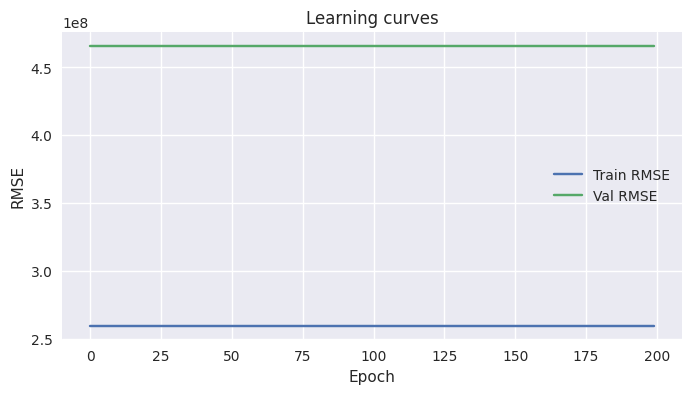

In [17]:
def run_epoch(loader, train: bool = True):
    se_total = 0.0
    count = 0
    if train:
        model.train()
    else:
        model.eval()
    for batch_x, batch_y in loader:
        if train:
            optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        if train:
            loss.backward()
            optimizer.step()
        se_total += torch.sum((preds - batch_y) ** 2).item()
        count += batch_x.size(0)
    return math.sqrt(se_total / count)

epochs = 200
train_history, val_history = [], []
for epoch in range(1, epochs + 1):
    train_rmse = run_epoch(train_loader, train=True)
    val_rmse = run_epoch(val_loader, train=False)
    train_history.append(train_rmse)
    val_history.append(val_rmse)
    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch {epoch:03d} | Train RMSE {train_rmse:.4f} | Val RMSE {val_rmse:.4f}')

plt.figure(figsize=(8,4))
plt.plot(train_history, label='Train RMSE')
plt.plot(val_history, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning curves')
plt.show()


## 8. Evaluate and compare predictions

Overall RMSE vs BS target: 311940219.2437


,S0,K,T,C_mkt,sigma_BS,sigma_pred
0,677.630127,350.000000,0.000950,0.010000,0.300000,"4,862.250488"
1,677.630127,355.000000,0.000950,0.020000,0.300000,"4,756.266113"
2,677.630127,360.000000,0.000950,0.010000,0.300000,"4,651.541992"
3,677.630127,365.000000,0.000950,0.010000,0.300000,"4,548.730469"
4,677.630127,370.000000,0.000950,0.010000,0.300000,"4,448.133789"


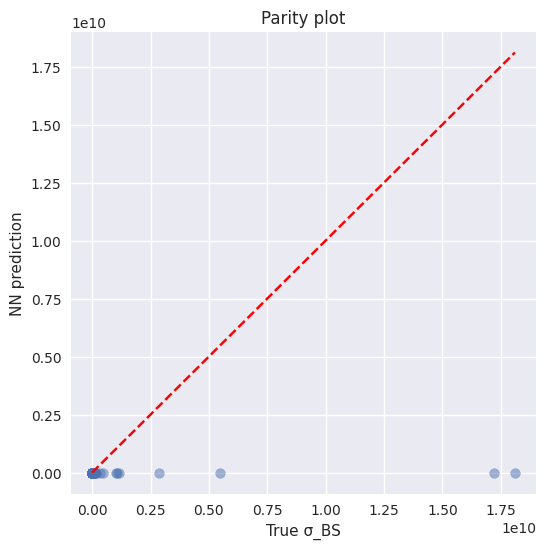

In [18]:
model.eval()
with torch.no_grad():
    preds = model(X_tensor).numpy().squeeze()
df['sigma_pred'] = preds
rmse_all = math.sqrt(np.mean((df['sigma_pred'] - df['sigma_BS']) ** 2))
print(f'Overall RMSE vs BS target: {rmse_all:.4f}')
display(df[['S0','K','T','C_mkt','sigma_BS','sigma_pred']].head())
plt.figure(figsize=(6,6))
plt.scatter(df['sigma_BS'], df['sigma_pred'], alpha=0.5)
plt.plot([df['sigma_BS'].min(), df['sigma_BS'].max()], [df['sigma_BS'].min(), df['sigma_BS'].max()], 'r--')
plt.xlabel('True σ_BS')
plt.ylabel('NN prediction')
plt.title('Parity plot')
plt.show()


## 10. Visualize NN-implied volatility surface

In [19]:
# Build a grid over maturity and moneyness, feeding the NN to get predicted σ.
m_grid = np.linspace(df['moneyness'].min(), df['moneyness'].max(), 40)
t_grid = np.linspace(df['T'].min(), df['T'].max(), 40)
T_mesh, M_mesh = np.meshgrid(t_grid, m_grid, indexing='ij')
# Use median S0 and C_mkt scaling from the dataset as stabilizers.
S0_ref = df['S0'].median()
price_ref = df['C_mkt'].median()
inputs = []
for t_val in t_grid:
    for m_val in m_grid:
        strike = S0_ref / max(m_val, 1e-8)
        inputs.append([S0_ref, strike, t_val, price_ref, m_val])
grid_array = np.array(inputs, dtype=np.float32)
grid_norm = (grid_array - X_mean) / X_std
with torch.no_grad():
    sigma_grid = model(torch.from_numpy(grid_norm)).numpy().reshape(len(t_grid), len(m_grid))

m_min, m_max = float(M_mesh.min()), float(M_mesh.max())
t_min, t_max = float(T_mesh.min()), float(T_mesh.max())
sigma_min, sigma_max = float(sigma_grid.min()), float(sigma_grid.max())

from mpl_toolkits.mplot3d import Axes3D  # noqa
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(M_mesh, T_mesh, sigma_grid, cmap='viridis', edgecolor='none')
ax.set_title('NN-predicted Implied Vol Surface')
ax.set_xlabel('Moneyness S0/K')
ax.set_ylabel('Maturity T (years)')
ax.set_zlabel('Implied Volatility (NN)')
ax.set_xlim(m_min, m_max)
ax.set_ylim(t_min, t_max)
ax.set_zlim(sigma_min, sigma_max)
fig.colorbar(surf, shrink=0.6, aspect=15, label='σ_pred')
plt.show()


ValueError: operands could not be broadcast together with shapes (1600,5) (6,) 

## 9. Helper for single-sample inference

In [ ]:
def predict_sigma(option_row: dict) -> float:
    vec = np.array([[option_row['S0'], option_row['K'], option_row['T'], option_row['C_mkt'], option_row['S0']/option_row['K']]], dtype=np.float32)
    vec_norm = (vec - X_mean) / X_std
    with torch.no_grad():
        pred = model(torch.from_numpy(vec_norm)).item()
    return pred

sample = df.iloc[0]
print('Example prediction:', predict_sigma({'S0': sample['S0'], 'K': sample['K'], 'T': sample['T'], 'C_mkt': sample['C_mkt']}))
print('True σ_BS:', sample['sigma_BS'])


Example prediction: 2.6893105506896973
True σ_BS: 7.5746269648257645
